In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree 
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.model_selection import KFold,train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import export_text
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm


In [2]:
df = pd.read_csv('Housing.csv')

In [3]:
df.head()

,SERIAL,DENSITY,OWNERSHP,OWNERSHPD,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,HHINCOME,VALUEH,...,NFAMS,NCOUPLES,PERNUM,PERWT,AGE,MARST,BIRTHYR,EDUC,EDUCD,INCTOT
0,1371772,920.0,1,13,9990,9993,360,9993,75000,700000,...,1,0,1,14,52,6,1969,7,71,75000
1,1371773,3640.9,2,22,1080,9993,1800,9993,13600,9999999,...,2,0,1,83,22,6,1999,10,101,5600
2,1371773,3640.9,2,22,1080,9993,1800,9993,13600,9999999,...,2,0,2,106,22,6,1999,7,71,8000
3,1371774,22.5,1,13,600,9993,9993,9993,7000,800000,...,1,0,1,33,62,4,1959,6,63,7000
4,1371775,3710.4,2,22,3600,9993,9997,9993,50500,9999999,...,1,0,1,297,50,3,1971,7,71,16000


In [4]:
df.shape

(75388, 24)

In [5]:
print(df[df['SERIAL'] == 1371783][['SERIAL', 'AGE']])

     SERIAL  AGE
20  1371783   40
21  1371783   32
22  1371783    9
23  1371783    3


In [6]:
#Removing duplicates from Serial by considering only eldest person of that HH
result_df = df.loc[df.groupby('SERIAL')['AGE'].idxmax()]

In [7]:
result_df.shape

(30802, 24)

In [8]:
print(result_df[result_df['SERIAL'] == 1371783][['SERIAL', 'AGE']])

     SERIAL  AGE
20  1371783   40


In [9]:
#Considering only persons with eductaional attainment as Master's Degree
housing_masters = result_df[result_df['EDUCD'] == 114].copy()

In [10]:
housing_masters.shape

(3570, 24)

In [11]:
len(result_df[result_df['EDUCD'] == 114])

3570

In [12]:
#Considering only the below columns. 7 predictors and 1 target
housing_df = housing_masters[['NCOUPLES', 'NFAMS', 'ROOMS', 'BEDROOMS', 'VEHICLES', 'AGE', 'MARST', 'OWNERSHP']].copy()

In [13]:
housing_df.shape

(3570, 8)

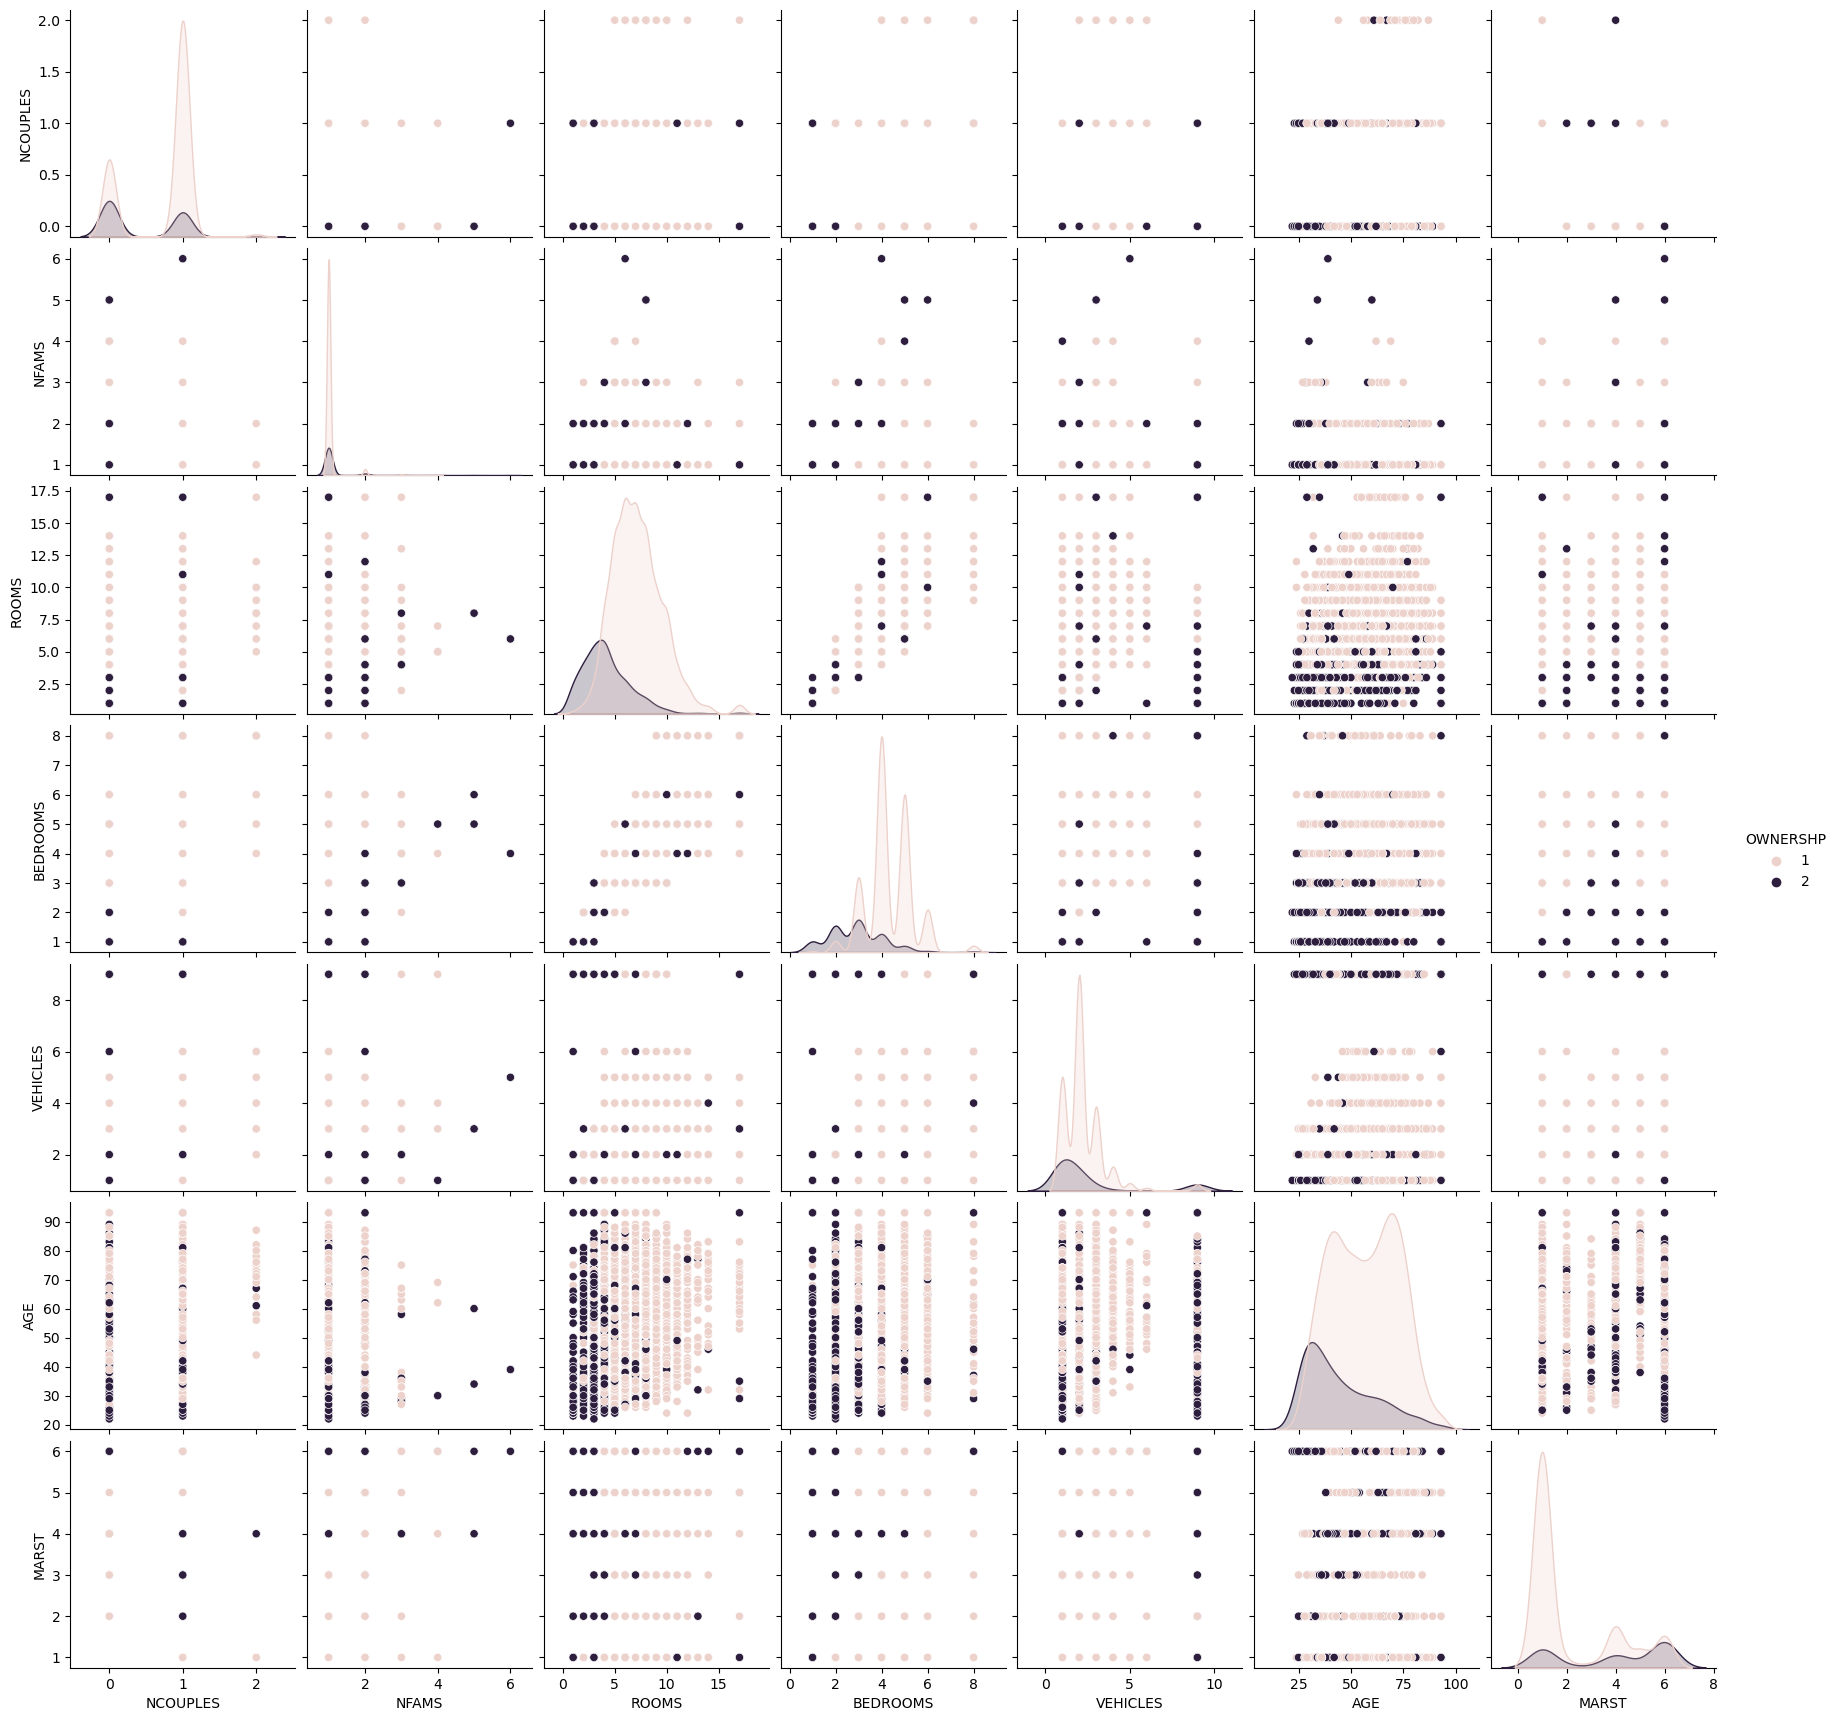

In [14]:
import seaborn as sns
sns.pairplot(housing_df, hue='OWNERSHP', diag_kind='kde')
plt.show()

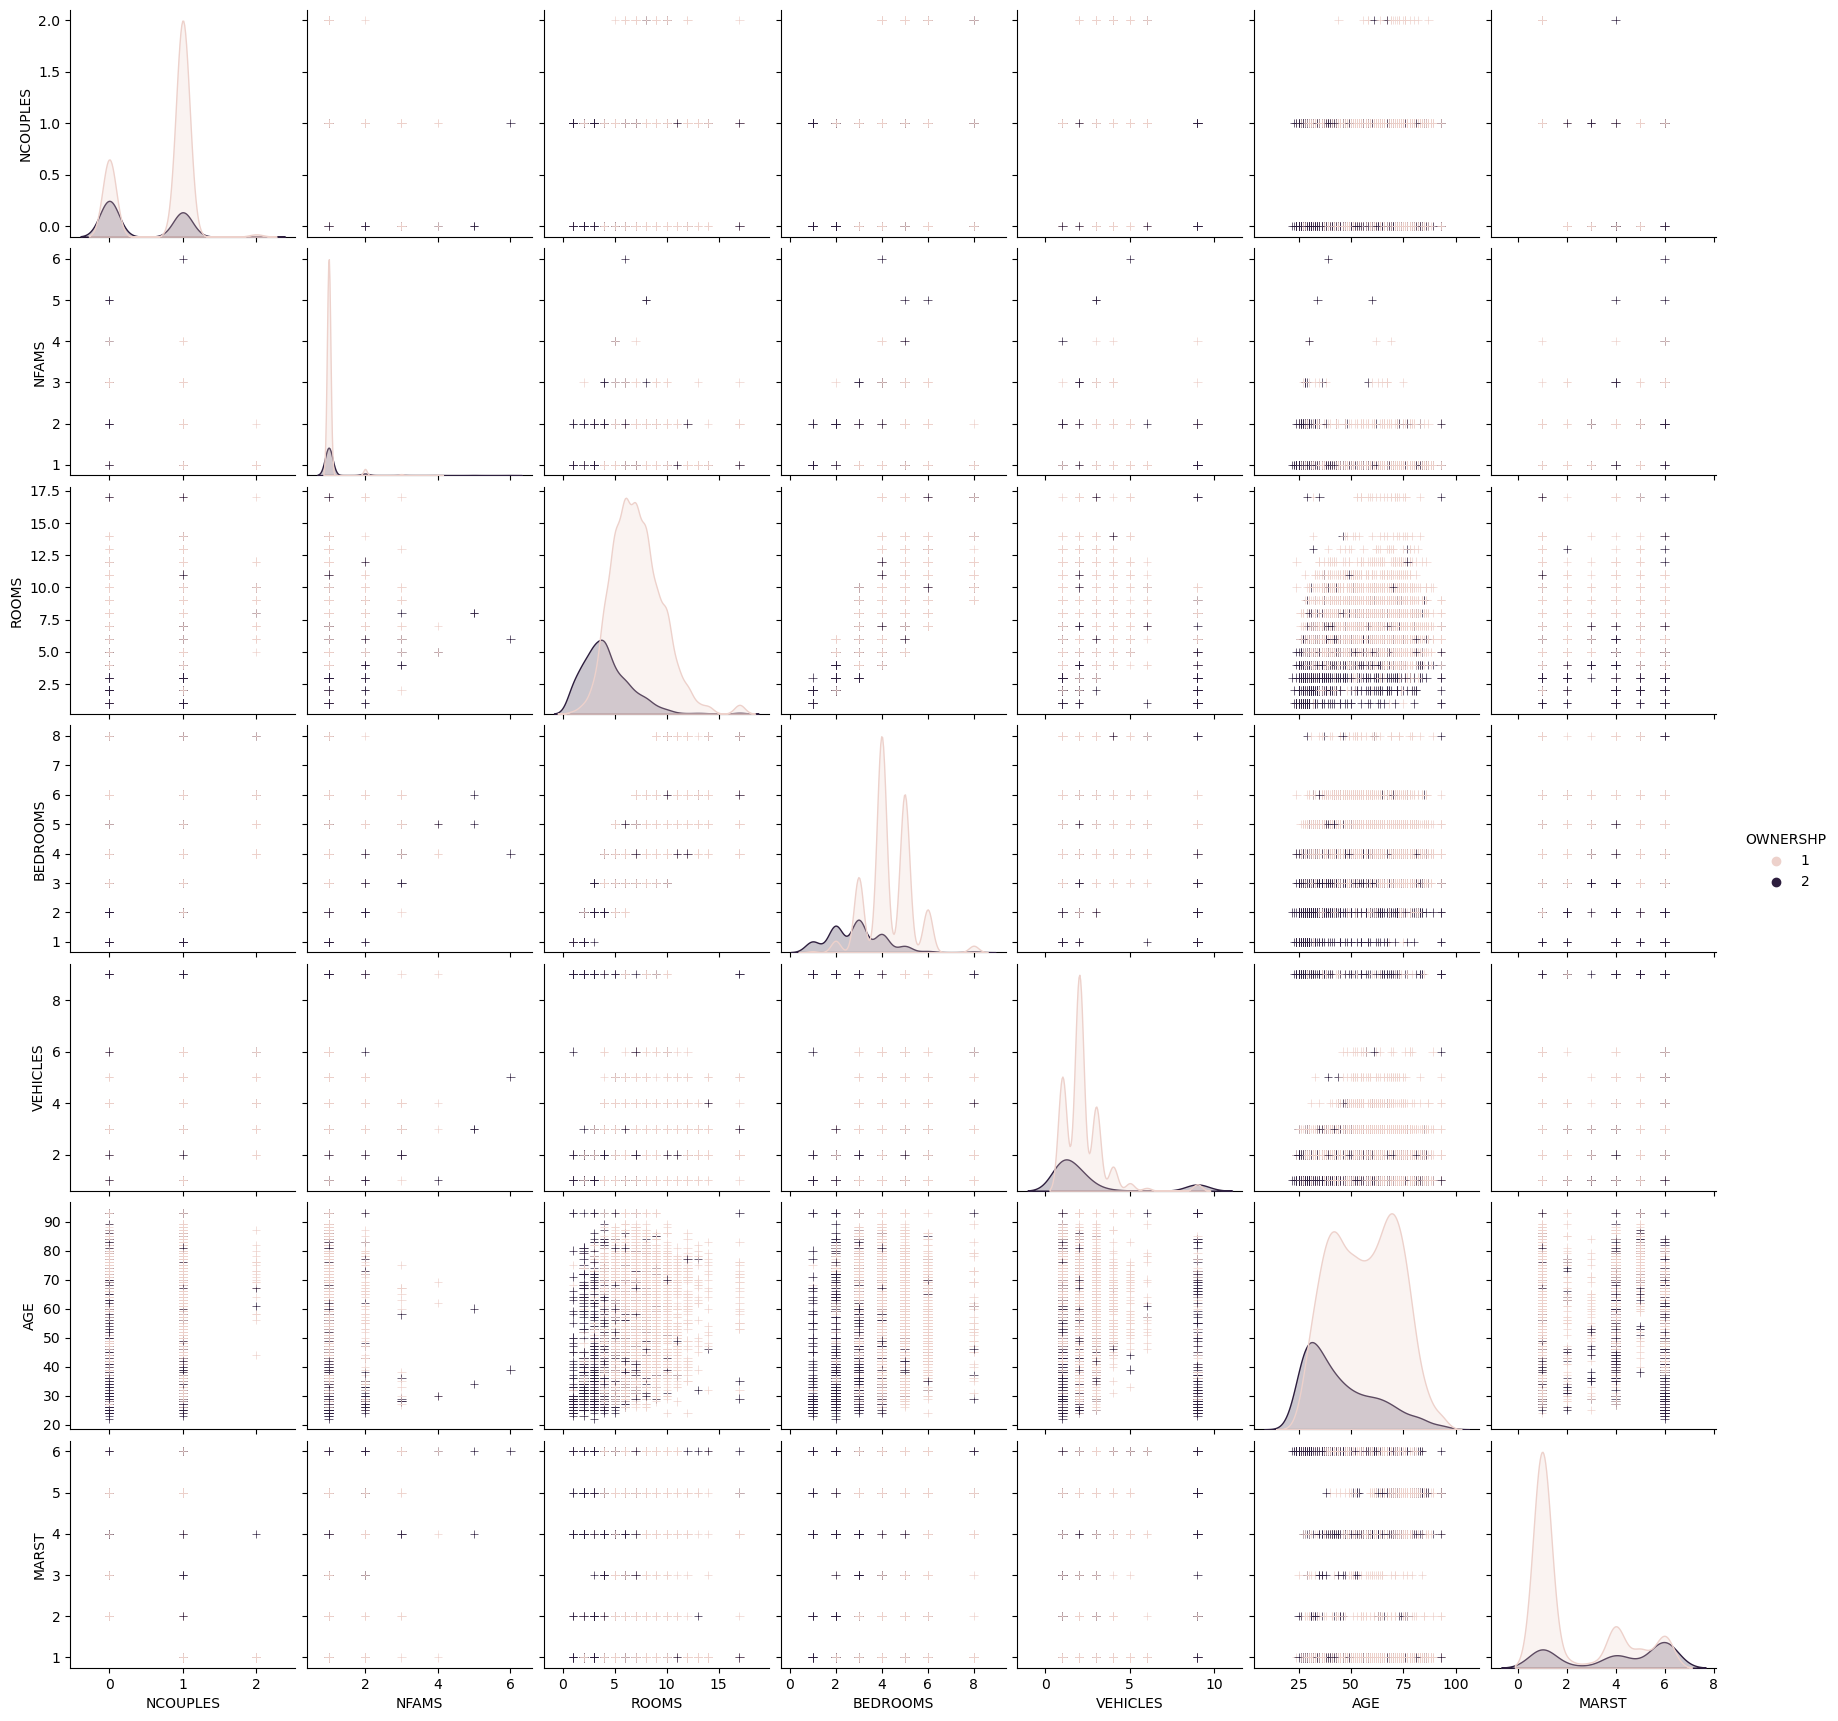

In [17]:
sns.pairplot(housing_df, hue='OWNERSHP', diag_kind='kde', vars=['NCOUPLES', 'NFAMS', 'ROOMS', 'BEDROOMS', 'VEHICLES', 'AGE', 'MARST'], markers='+')
plt.show()

In [15]:
# Split the dataset into features (X) and target variable (y)
X = housing_df.drop(columns=['OWNERSHP'])
y = housing_df['OWNERSHP']


In [16]:
# Convert 'mrjflag' and 'tobflag' to categorical variables
X['MARST'] = X['MARST'].astype('category')

In [17]:
#Splitting the data into Training and Testing set
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)

In [18]:
# One-hot encoding for categorical variables
X_train = pd.get_dummies(X_train_1, columns=['MARST'])
X_test = pd.get_dummies(X_test_1, columns=['MARST'])

In [19]:
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2677, 12)
Test set shape: (893, 12)


Linear

In [20]:
svm_linear = SVC(C=1, kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [21]:
print('Number of support vectors for each class are ',svm_linear.n_support_)

Number of support vectors for each class are  [472 472]


In [22]:
train_predictions = svm_linear.predict(X_train)

In [23]:
confusion_table(train_predictions,y_train)

Truth,1,2
Predicted,,
1,2008,300
2,83,286


In [24]:
print('Training Accuracy is ',svm_linear.score(X_train,y_train))
train_error = 1 - accuracy_score(y_train, train_predictions)
print("Training Error Rate:", train_error)

Training Accuracy is  0.8569293985805005
Training Error Rate: 0.14307060141949945


In [25]:
test_predictions = svm_linear.predict(X_test)

In [26]:
confusion_table(test_predictions,y_test)

Truth,1,2
Predicted,,
1,661,102
2,21,109


In [27]:
print('Test Accuracy is ',svm_linear.score(X_test,y_test))
test_error = 1 - accuracy_score(y_test, test_predictions)
print("Testing Error Rate:", test_error)

Test Accuracy is  0.8622620380739082
Testing Error Rate: 0.13773796192609178


[[661  21]
 [102 109]]


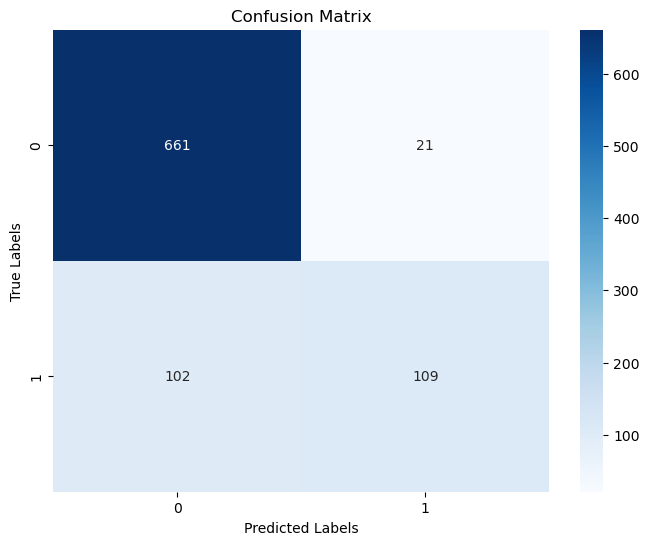

In [28]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_predictions)
print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [29]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

svc = SVC(kernel='linear')

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X, y)
print(grid_search.best_params_)

best_svc = SVC(kernel='linear', C=grid_search.best_params_['C'])
best_svc.fit(X_train, y_train)

y_train_pred = best_svc.predict(X_train)
y_test_pred = best_svc.predict(X_test)

# Calculate training and testing errors
train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

# Print the errors
print("Training Error:", train_error)
print("Testing Error:", test_error)

{'C': 0.01}
Training Error: 0.14269704893537538
Testing Error: 0.13437849944008962


In [30]:
svm_linear_1 = SVC(C=0.01, kernel='linear')
svm_linear_1.fit(X_train, y_train)

SVC(C=0.01, kernel='linear')

In [79]:
print('Number of support vectors for each class are ',svm_linear_1.n_support_)

Number of support vectors for each class are  [496 493]


In [80]:
y_pred_train_linear = svm_linear_1.predict(X_train)
y_pred_test_linear = svm_linear_1.predict(X_test)

# Calculate the error rates for linear SVM
train_error_linear = 1 - accuracy_score(y_train, y_pred_train_linear)
test_error_linear = 1 - accuracy_score(y_test, y_pred_test_linear)

print('Training Accuracy is ',svm_linear_1.score(X_train,y_train))
print('Test Accuracy is ',svm_linear_1.score(X_test,y_test))
print("Training Error Rate:", train_error_linear)
print("Testing Error Rate:", test_error_linear)

Training Accuracy is  0.8573029510646246
Test Accuracy is  0.8656215005599104
Training Error Rate: 0.14269704893537538
Testing Error Rate: 0.13437849944008962


[[668  14]
 [106 105]]


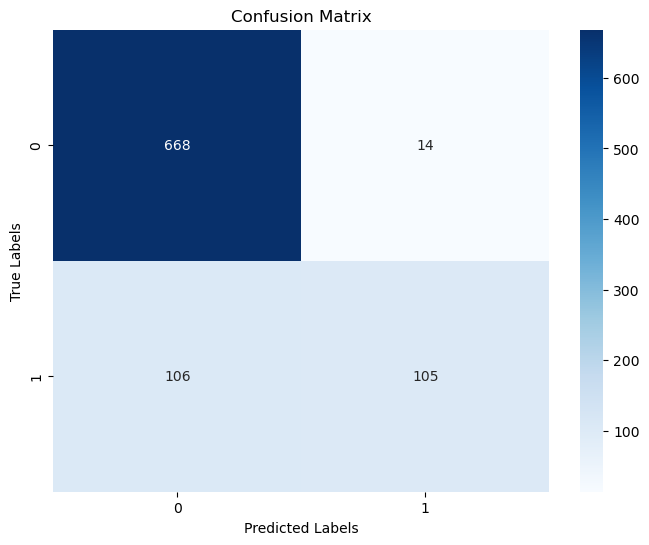

In [33]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_linear)
print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [57]:
# Get coefficients
coefficients = svm_linear_1.coef_[0]
print(coefficients)

# Get indices of top two predictors
top_two_indices = np.argsort(np.abs(coefficients))[-2:]
print(top_two_indices)

[-0.12281785  0.16021206 -0.09982902 -0.56211974  0.07653129 -0.0220458
 -0.17432715  0.01030002  0.01        0.01185841  0.04        0.10216872]
[6 3]


In [61]:
feature_names = X_train.columns.tolist()
print("Feature Names:", feature_names)
# Assuming feature_names is a list containing the names of all features in your dataset
top_two_predictor_names = [feature_names[i] for i in top_two_indices]
print("Top Two Predictor Names:", top_two_predictor_names)


Feature Names: ['NCOUPLES', 'NFAMS', 'ROOMS', 'BEDROOMS', 'VEHICLES', 'AGE', 'MARST_1', 'MARST_2', 'MARST_3', 'MARST_4', 'MARST_5', 'MARST_6']
Top Two Predictor Names: ['MARST_1', 'BEDROOMS']


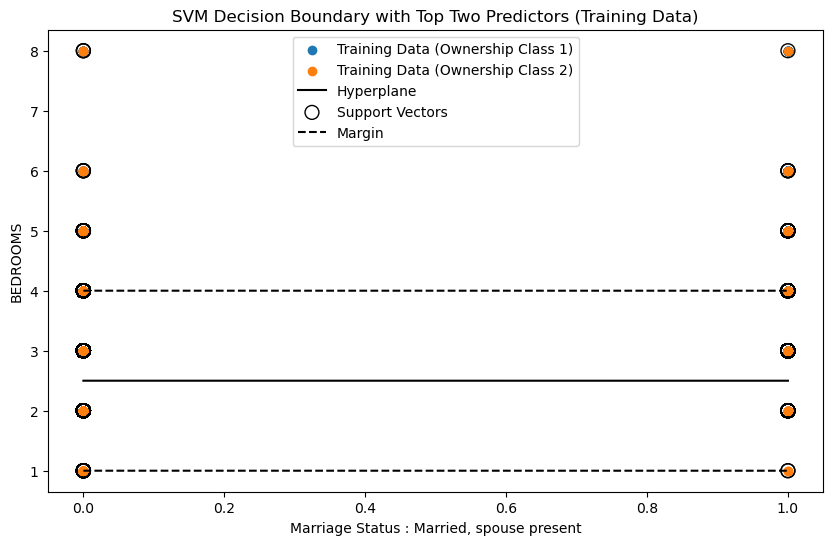

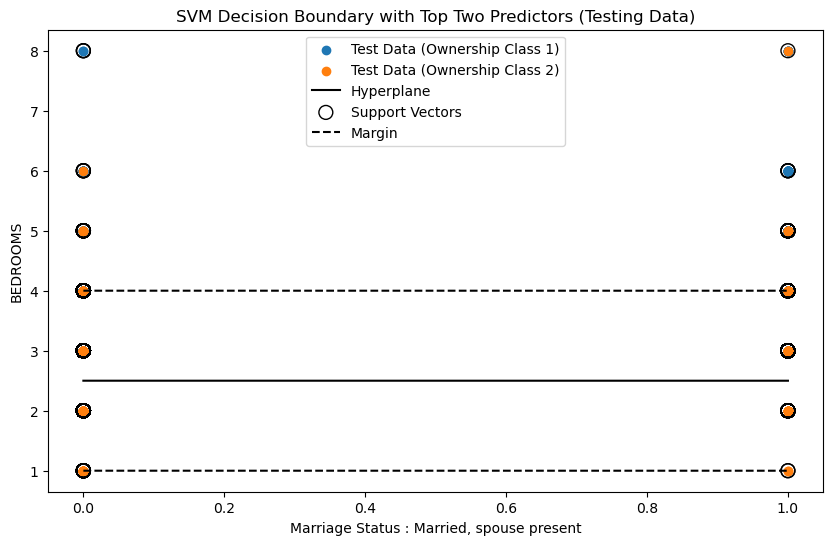

In [87]:
X_train_top_two = X_train[['MARST_1', 'BEDROOMS']].values
X_test_top_two = X_test[['MARST_1', 'BEDROOMS']].values

svm_linear_top_two = SVC(C=0.01, kernel='linear')
svm_linear_top_two.fit(X_train_top_two, y_train)

plt.figure(figsize=(10, 6))

for label in np.unique(y_train):
    plt.scatter(X_train_top_two[y_train == label, 0], X_train_top_two[y_train == label, 1],
                label=f'Training Data (Ownership Class {label})')

# Plot decision boundary (hyperplane) for training data
w = svm_linear_top_two.coef_[0]
b = svm_linear_top_two.intercept_[0]
xx = np.linspace(min(X_train_top_two[:, 0]), max(X_train_top_two[:, 0]), 100)
yy = -w[0] / w[1] * xx - b / w[1]
plt.plot(xx, yy, 'k-', label='Hyperplane')

support_vectors = svm_linear_top_two.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], marker='o', s=100, facecolors='none', edgecolors='k', label='Support Vectors')

margin = 1 / np.sqrt(np.sum(svm_linear_top_two.coef_ ** 2))
yy_down = yy - np.sqrt(1 + (w[0] / w[1]) ** 2) * margin
yy_up = yy + np.sqrt(1 + (w[0] / w[1]) ** 2) * margin
plt.plot(xx, yy_down, 'k--', label='Margin')
plt.plot(xx, yy_up, 'k--')

plt.xlabel('Marriage Status : Married, spouse present')
plt.ylabel('BEDROOMS')
plt.title('SVM Decision Boundary with Top Two Predictors (Training Data)')
plt.legend()
plt.show()

# Plot data points along with hyperplane for testing data
plt.figure(figsize=(10, 6))

for label in np.unique(y_test):
    plt.scatter(X_test_top_two[y_test == label, 0], X_test_top_two[y_test == label, 1],
                label=f'Test Data (Ownership Class {label})')

plt.plot(xx, yy, 'k-', label='Hyperplane')

support_vectors = svm_linear_top_two.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], marker='o', s=100, facecolors='none', edgecolors='k', label='Support Vectors')

plt.plot(xx, yy_down, 'k--', label='Margin')
plt.plot(xx, yy_up, 'k--')

plt.xlabel('Marriage Status : Married, spouse present')
plt.ylabel('BEDROOMS')
plt.title('SVM Decision Boundary with Top Two Predictors (Testing Data)')
plt.legend()
plt.show()


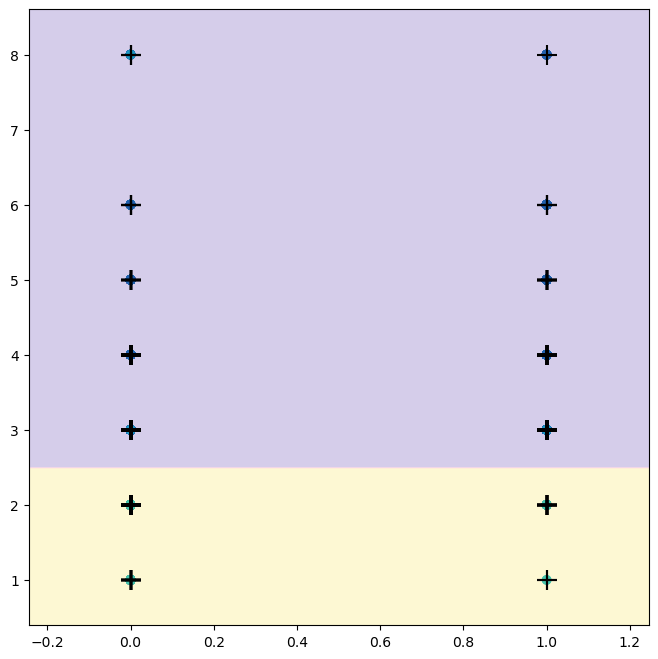

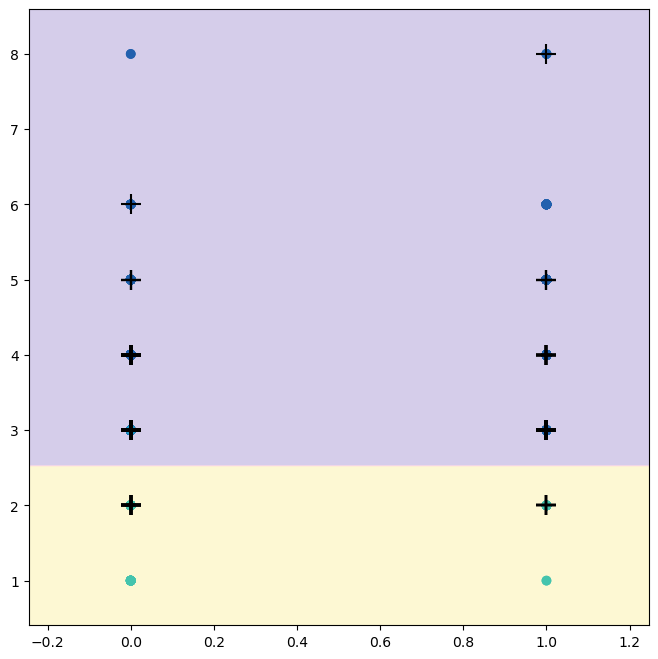

In [78]:
from ISLP.svm import plot as plot_svm
from matplotlib.pyplot import subplots, cm
# Extract top two predictors from training and testing datasets
X_train_top_two = X_train[['MARST_1', 'BEDROOMS']].values
X_test_top_two = X_test[['MARST_1', 'BEDROOMS']].values

# Fit SVM model with only top two predictors
svm_linear_top_two = SVC(C=0.01, kernel='linear')
svm_linear_top_two.fit(X_train_top_two, y_train)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_train_top_two,
         y_train,
         svm_linear_top_two,
         ax=ax)

# Fit SVM model with only top two predictors
svm_linear_top_two_test = SVC(C=0.01, kernel='linear')
svm_linear_top_two_test.fit(X_test_top_two, y_test)
fig, ax = subplots(figsize=(8,8))
plot_svm(X_test_top_two,
         y_test,
         svm_linear_top_two_test,
         ax=ax)

Radial Kernel

In [34]:
svm_rbf = SVC(kernel="rbf")
svm_rbf.fit(X_train, y_train)

SVC()

In [35]:
print('Number of support vectors for each class are ',svm_rbf.n_support_)

Number of support vectors for each class are  [552 549]


In [36]:
train_predictions = svm_rbf.predict(X_train)
confusion_table(train_predictions,y_train)

Truth,1,2
Predicted,,
1,2050,380
2,41,206


In [37]:
print('Training Accuracy is ',svm_rbf.score(X_train,y_train))
print('Training Error Rate is ',1 - svm_rbf.score(X_train,y_train))

Training Accuracy is  0.8427344041837879
Training Error Rate is  0.15726559581621213


In [38]:
test_predictions = svm_rbf.predict(X_test)
confusion_table(test_predictions,y_test)

Truth,1,2
Predicted,,
1,671,139
2,11,72


In [39]:
print('Testing Accuracy is ',svm_rbf.score(X_test,y_test))
print('Testing Error Rate is ',1 - svm_rbf.score(X_test,y_test))

Testing Accuracy is  0.832026875699888
Testing Error Rate is  0.16797312430011202


In [40]:
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 100]}

svc = SVC(kernel='rbf')

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

print(grid_search.best_params_)

best_svc = SVC(kernel='rbf', C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
best_svc.fit(X_train, y_train)

y_pred = best_svc.predict(X_test)

y_train_pred = best_svc.predict(X_train)
y_test_pred = best_svc.predict(X_test)

# Calculate training and testing errors
train_error = 1 - accuracy_score(y_train, y_train_pred)
test_error = 1 - accuracy_score(y_test, y_test_pred)

# Print the errors
print("Training Error:", train_error)
print("Testing Error:", test_error)

{'C': 1, 'gamma': 0.1}
Training Error: 0.11654837504669402
Testing Error: 0.13773796192609178


In [41]:
svm_rbf_1 = SVC(kernel="rbf", gamma=0.1, C=1)
svm_rbf_1.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

In [81]:
print('Number of support vectors for each class are ',svm_rbf_1.n_support_)

Number of support vectors for each class are  [711 457]


In [42]:
y_pred_train_linear = svm_rbf_1.predict(X_train)
y_pred_test_linear = svm_rbf_1.predict(X_test)

# Calculate the error rates for linear SVM
train_error_linear = 1 - accuracy_score(y_train, y_pred_train_linear)
test_error_linear = 1 - accuracy_score(y_test, y_pred_test_linear)

print('Training Accuracy is ',svm_rbf_1.score(X_train,y_train))
print('Test Accuracy is ',svm_rbf_1.score(X_test,y_test))
print("Training Error Rate:", train_error_linear)
print("Testing Error Rate:", test_error_linear)

Training Accuracy is  0.883451624953306
Test Accuracy is  0.8622620380739082
Training Error Rate: 0.11654837504669402
Testing Error Rate: 0.13773796192609178


[[667  15]
 [108 103]]


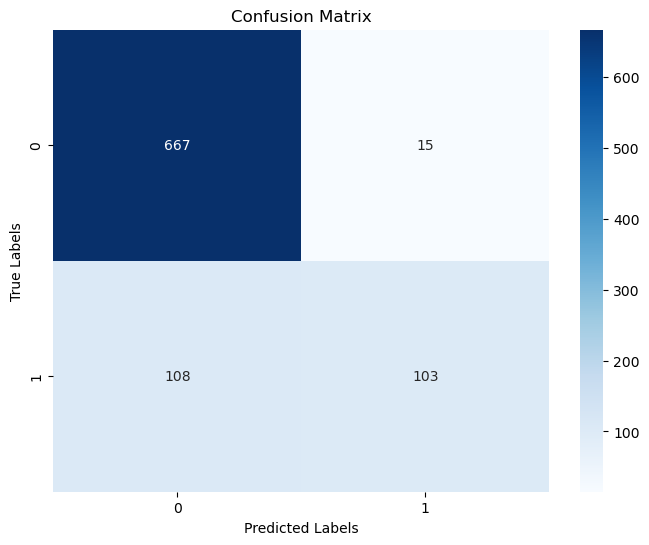

In [43]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_linear)
print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Poly Kernel

In [44]:
svm_poly = SVC(kernel="poly", degree=1)
svm_poly.fit(X_train, y_train)

SVC(degree=1, kernel='poly')

In [45]:
print('Number of support vectors for each class are ',svm_poly.n_support_)

Number of support vectors for each class are  [588 586]


In [46]:
train_predictions = svm_poly.predict(X_train)
confusion_table(train_predictions,y_train)

Truth,1,2
Predicted,,
1,2082,472
2,9,114


In [47]:
print('Training Accuracy is ',svm_poly.score(X_train,y_train))
print('Training Error Rate is ',1 - svm_poly.score(X_train,y_train))

Training Accuracy is  0.8203212551363467
Training Error Rate is  0.17967874486365332


In [48]:
test_predictions = svm_poly.predict(X_test)
confusion_table(test_predictions,y_test)

Truth,1,2
Predicted,,
1,679,173
2,3,38


In [49]:
print('Testing Accuracy is ',svm_poly.score(X_test,y_test))
print('Testing Error Rate is ',1 - svm_poly.score(X_test,y_test))

Testing Accuracy is  0.8029115341545353
Testing Error Rate is  0.1970884658454647


In [51]:
svm_poly = SVC(kernel="poly")
svm_poly.fit(X_train, y_train)
kfold = skm.KFold(5, 
                  random_state=17,
                  shuffle=True)
grid = skm.GridSearchCV(svm_poly,
                        {'C':[0.1,1,10,100,1000],
                         'degree':[1,2,3,4]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy');
grid.fit(X_train, y_train)
grid.best_params_

{'C': 10, 'degree': 2}

In [52]:
svm_poly_1 = SVC(kernel="poly", degree=2, C=10)
svm_poly_1.fit(X_train, y_train)

SVC(C=10, degree=2, kernel='poly')

In [82]:
print('Number of support vectors for each class are ',svm_poly_1.n_support_)

Number of support vectors for each class are  [531 530]


In [53]:
y_pred_train_linear = svm_poly_1.predict(X_train)
y_pred_test_linear = svm_poly_1.predict(X_test)

# Calculate the error rates for linear SVM
train_error_linear = 1 - accuracy_score(y_train, y_pred_train_linear)
test_error_linear = 1 - accuracy_score(y_test, y_pred_test_linear)

print('Training Accuracy is ',svm_poly_1.score(X_train,y_train))
print('Test Accuracy is ',svm_poly_1.score(X_test,y_test))
print("Training Error Rate:", train_error_linear)
print("Testing Error Rate:", test_error_linear)

Training Accuracy is  0.8591707134852447
Test Accuracy is  0.8678611422172452
Training Error Rate: 0.14082928651475535
Testing Error Rate: 0.1321388577827548


[[669  13]
 [105 106]]


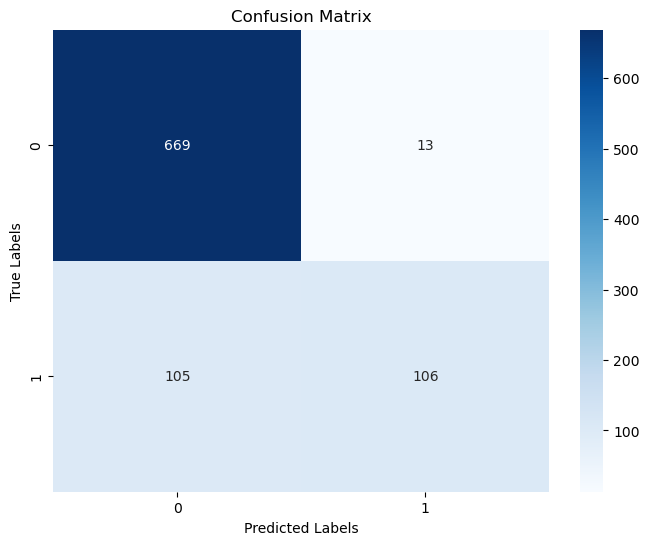

In [54]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_linear)
print(cm)
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()